In [3]:
# Importing necessary libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading the data
df = pd.read_csv('dataset.csv')
df.head()

,order_id,customer_number,transaction_date,description,total_qty,net_total,loyalty_amount,loyalty_points,discount_amount,customer_group,territory,delivery_date,delivery_window_end_time,delivery_window_start_time,set_warehouse,duka_latitude,duka_longitude
0,04aeddd4-d9b3-4cca-ab3b-072ca177a3e1,ID_172101,28/03/2022,Steam Energy Energy Drink 400ML CARTON (1.0 Item),6,2231.57,0,0,66.38,Individual,Meru,29/03/2022,19:00:00,13:00:00,Meru Main - KDKE,0.036784,37.654155
1,04aeddd4-d9b3-4cca-ab3b-072ca177a3e1,ID_172101,28/03/2022,Sumo Candles 8PC CARTON (12.0 Outers),6,2231.57,0,0,66.38,Individual,Meru,29/03/2022,19:00:00,13:00:00,Meru Main - KDKE,0.036784,37.654155
2,04aeddd4-d9b3-4cca-ab3b-072ca177a3e1,ID_172101,28/03/2022,Rhino Matches Kubwa 10 Boxes OUTER (1.0 Item),6,2231.57,0,0,66.38,Individual,Meru,29/03/2022,19:00:00,13:00:00,Meru Main - KDKE,0.036784,37.654155
3,4da580db-3b2c-4dff-a181-9c1341e05ea5,ID_172101,12/03/2022,Dawn Tissue Rolls Smart 40PC BALE (1.0 Bale),5,3637.91,0,0,38.53,Individual,Meru,14/03/2022,14:00:00,08:00:00,Meru Main - KDKE,0.036784,37.654155
4,4da580db-3b2c-4dff-a181-9c1341e05ea5,ID_172101,12/03/2022,Sawa Bath Soap 125G White DOZEN (1.0 Dzn),5,3637.91,0,0,38.53,Individual,Meru,14/03/2022,14:00:00,08:00:00,Meru Main - KDKE,0.036784,37.654155


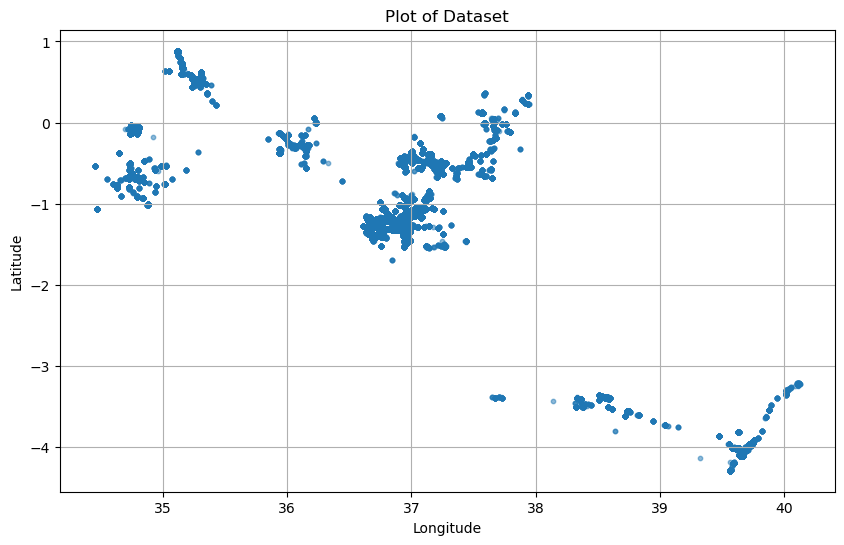

In [7]:
# Plotting the location of the shops

plt.figure(figsize=(10, 6))
plt.scatter(df['duka_longitude'], df['duka_latitude'], alpha=0.5, s=10)
plt.title('Plot of Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [9]:
# Checking for null values

df.isna().sum()

order_id                      0
customer_number               0
transaction_date              0
description                   0
total_qty                     0
net_total                     0
loyalty_amount                0
loyalty_points                0
discount_amount               0
customer_group                0
territory                     0
delivery_date                 0
delivery_window_end_time      0
delivery_window_start_time    0
set_warehouse                 0
duka_latitude                 0
duka_longitude                0
dtype: int64

Since clustering analysis based on the location of the shops is what is being performed, the only information required are the location details which in this case is the `duka_latitude` and `duka_longitude` columns. A new dataset will therefore be created conatining the relevant information.

In [12]:
df_new = df[['duka_latitude', 'duka_longitude']]
df_new.head()

,duka_latitude,duka_longitude
0,0.036784,37.654155
1,0.036784,37.654155
2,0.036784,37.654155
3,0.036784,37.654155
4,0.036784,37.654155


For the algorithm to be used for analysis, I have decided to use <b>K-Means Clustering</b> since this specific problem falls under partional clustering and this algorithm is appropriate for such a scenario. K-Means is also centroid based meaning it is useful for determining the fulfillment centres.

### Clustering Algorithm

In [16]:
from sklearn.cluster import KMeans

Before employing the algorithm, the number of fullfillment centers has to be decided first. This is determined by the value `k`. This value will be determined using the <b>elbow method</b>. 

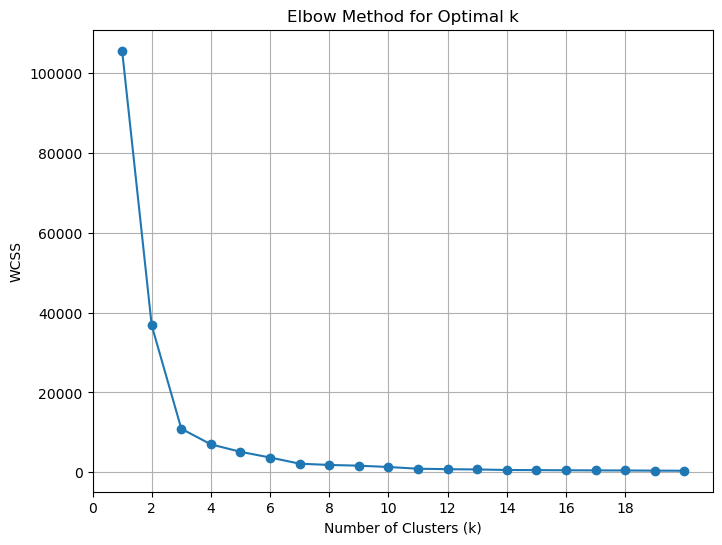

In [21]:
# Range of values to test k
k_values= range(1,21)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_new)
    inertia.append(kmeans.inertia_)

# Plotting the graph

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.xticks(range(0,20,2))
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

The Elbow method works by checking the <b>within-cluster sum of squares (WCSS)</b> which is the total distancxe between each  point and its corrresponding cluster centroid.

At the beginning when `k` is small, adding more clusters  significantly reduces the WCSS. As `k` increases the rate of WCSS reduction decreases. The 'Elbow' is the point where the WCSS reduction rate significantly reduces and increasing the number of clusters `k` past this point has minimal impact on the WCSS hence this is considered the optimum value for `k`.
From the graph above the elbow point is seen to be around 2.5. This can be rounded to the next closest value on the axis which is 4.

This therefore means, given the number and location of shops in the dataset, for optimum dynamic routing, the number of fulfillment centers has to be 4.

In [26]:
# Fitting the model
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_new)

KMeans(n_clusters=4)

In [28]:
cluster_labels = kmeans.predict(df_new)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

#### Plotting the ciusters

In [35]:
import geopandas as gpd
from shapely.geometry import Point

df['cluster'] = cluster_labels

# Convert shops data to GeoDataFrame
shops_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.duka_longitude, df.duka_latitude))

# Convert centroids to GeoDataFrame
centers_df = pd.DataFrame(centers, columns=['duka_latitude', 'duka_longitude'])
centers_gdf = gpd.GeoDataFrame(centers_df, geometry=gpd.points_from_xy(centers_df.duka_longitude, centers_df.duka_latitude))

# Assign a cluster label to the centroids for consistent coloring
centers_gdf['cluster'] = range(4)

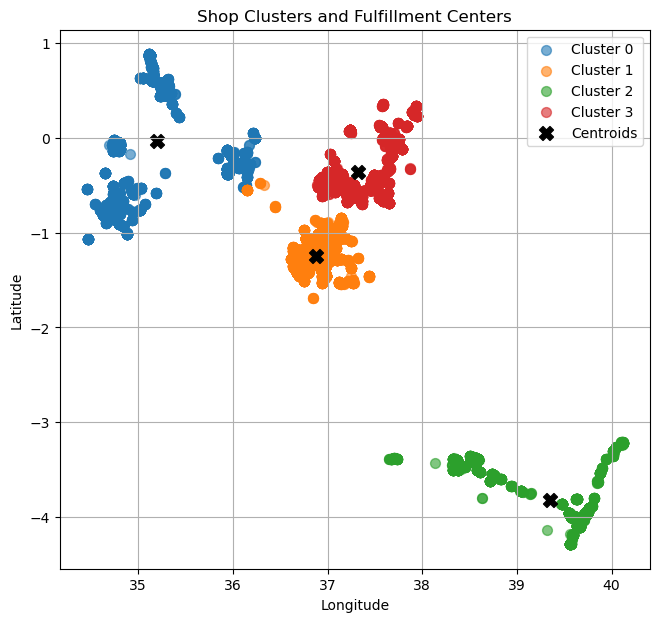

In [37]:
# Plot the clusters and centroids
fig, ax = plt.subplots(figsize=(8, 7))

# Plot shops with different colors based on cluster
for cluster in range(4):
    
    cluster_shops = shops_gdf[shops_gdf['cluster'] == cluster]
    cluster_shops.plot(ax=ax, markersize=50, label=f'Cluster {cluster}', alpha=0.6)

# Plot centroids
centers_gdf.plot(ax=ax, color='black', markersize=100, marker='X', label='Centroids')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Shop Clusters and Fulfillment Centers')
plt.legend()
plt.grid(True)
plt.show()

Once analysis is complete it is appropriate to display the findings in a single file. For this file I decided to use the `customer_number` as my identifier. To add this column to the new dataframe to be created I have to first seperate it from the original dataframe.

In [40]:
customer_num = df['customer_number']
customer_num.head()

0    ID_172101
1    ID_172101
2    ID_172101
3    ID_172101
4    ID_172101
Name: customer_number, dtype: object

In [45]:
# Creating the new dataframe and adding the customer_number identifier
df_cluster = pd.DataFrame({
    'customer_number': customer_num,
    'duka_latitude': df_new['duka_latitude'],
    'duka longitude': df_new['duka_longitude'],
    'cluster': cluster_labels
})
df_cluster.head()

,customer_number,duka_latitude,duka longitude,cluster
0,ID_172101,0.036784,37.654155,3
1,ID_172101,0.036784,37.654155,3
2,ID_172101,0.036784,37.654155,3
3,ID_172101,0.036784,37.654155,3
4,ID_172101,0.036784,37.654155,3
